Given
$ \displaystyle
    \frac{d^2 y}{d x^2} - \frac{c_1 y}{c_2 + y} = 0
$
find $y$

<!-- $ \displaystyle
\mathcal{L} = \int_{C} \left| \frac{d^2 y}{d x^2} - \frac{c_1 y}{c_2 + y} \right| \; dC
$ -->

$ \displaystyle
\mathcal{L} = \int_{C} \left( \frac{d^2 y}{d x^2} - \frac{c_1 y}{c_2 + y} \right)^2 \; dC
$


$C$ – $c_1$, $c_2$ space


\begin{cases}
    c_1 = \sigma^2 \quad \text{(normalized)}\\
    c_2 = 1
\end{cases}



# DARTS

$ \displaystyle
\overline{o}^{(i, j)}(x) = \sum_{o \in \mathcal{O}} \left( \alpha_o^{(i,j)} o(x) \right)
\\ \displaystyle
\forall (i, j) \; R = (\sum_{o \in \mathcal{O}} \alpha_o^{(i, j)} - 1)^2
$

# Code

In [1]:
import sympy as sp
from jax import random
import jax.numpy as np

# !rm /etc/localtime
# !ln -s /usr/share/zoneinfo/Europe/Vilnius /etc/localtime

from util.plot import Plotting
from util.print import a, d, pad, info
from util.dotdict import DotDict
from network import Network
from train import train

In [2]:
# def actual_func(z, c_1, c_2=1, c_3=0):
#     return c_1 * z - c_2 * c_1 * np.log(c_2 + z) + c_3

In [3]:
c1 = sp.symbols('c_1')
x_bounds = (0, 1)
c1_bounds = (0.01, 0.2)

In [4]:
loss_model_func = lambda model_y, x, model_d2y: sp.Pow(model_d2y - c1 * (model_y) / (1 + model_y), 2, evaluate=False)
loss_integration_func = lambda loss_model: (loss_model, (c1, *c1_bounds))

In [5]:
def orig_func(x, c2):
  S_0 = 1
  d = 1
  alpha = np.sqrt(c2)
  return S_0 * np.cosh(alpha * x) / np.cosh(alpha * d)

In [6]:
cell_count = 4
network = Network(
  loss_model_func,
  loss_integration_func,
  [
    lambda z: 0,
    lambda z: 1,
    lambda z: z,
    lambda z: 1 + z,
    lambda z: -z,
    lambda z: z*z,
    lambda z: z*z*z*z,
    lambda z: (sp.exp(z) + sp.exp(-z)) / 2,
    # lambda z: sp.sin(z),
    # lambda z: sp.exp(z),
    # lambda z: sp.Max(z, np.array(0)),
    # lambda z: 1 / (1 + sp.exp(-z))
  ],
  cell_count,
  x_bounds,
  verbose=1
)

_, model_y, loss_and_grad, _ = network.get_model()

11:26:43.531 [INFO] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
11:26:43.532 [INFO] Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
11:26:43.533 [INFO] Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
11:26:43.914 [INFO] Constructed symbolic model
11:26:43.969 [INFO] Integrated
11:26:45.470 [INFO] Added boundary condition
11:26:46.492 [INFO] Lambdified
11:26:46.493 [INFO] Constructed JAXified model


In [7]:
plotting = Plotting(orig_func, network, x_bounds, c1_bounds)

key = random.PRNGKey(7)

key, subkey = random.split(key)
W = random.uniform(subkey, shape=(len(network.alphas),), minval=0, maxval=0.001)

is_final = False

best = DotDict({"loss": np.inf})

while not is_final:
    plotting.funcs = []
    train_results = train(
        network,
        dataset = [(1, 1)],
        plotting = plotting,
        key = key,
        lr = 0.0002,
        lr_2 = 0.001,
        epochs = 30,
        verbose = 0,
        batch_size = 16,
        W_init = W,
        best = best
    )

    W = train_results.W
    loss_history = train_results.loss_history

    info('Pruning weights...')
    network.assign_weights(W)
    W, model_y, loss_and_grad, is_final = network.prune_auto()

KeyError: ('W',)

In [ ]:
float(best.loss)

0.0008529452607035637

In [ ]:
y_prediction_last = model_y.subs(zip(network.alphas, W))
y_prediction_last

0.0941669441151376*x + 0.90496963262558

In [ ]:
y_prediction_best = best.model_y.subs(zip(best.alphas, best.W))
y_prediction_best

0.000356950975009761*x**4 + 0.00806085478207511*x**2 + 0.0734665183777514*x + 0.000397161414527165*(0.00159436748046647*x**4 + 0.0267749518584571*x**2 - x + 0.165791414891482*exp(0.232024967670441*x) + 0.62833969796034 + 0.165791414891482*exp(-0.232024967670441*x))**4 + 0.00536580133280784*(0.00159436748046647*x**4 + 0.0267749518584571*x**2 - x + 0.165791414891482*exp(0.232024967670441*x) + 0.62833969796034 + 0.165791414891482*exp(-0.232024967670441*x))**2 + 0.0442332706595044*exp(0.232024967670441*x) + 0.0250708367675543*exp(x) + 0.0392199507560371*exp(-0.000426375986234416*x**4 - 0.00716032950050424*x**2 + 0.267426419227812*x - 0.0443370044231415*exp(0.232024967670441*x) - 0.0443370044231415*exp(-0.232024967670441*x)) + 0.0548858095055828*exp(0.000426375986234416*x**4 + 0.00716032950050424*x**2 - 0.267426419227812*x + 0.0443370044231415*exp(0.232024967670441*x) + 0.0443370044231415*exp(-0.232024967670441*x)) + 0.656584621772166 + 0.0250708367675543*exp(-x) + 0.0442332706595044*exp(-0

In [ ]:
y_prediction_best.rewrite(sp.cos)

0.000356950975009761*x**4 + 0.00806085478207511*x**2 + 0.0734665183777514*x + 0.000397161414527165*(0.00159436748046647*x**4 + 0.0267749518584571*x**2 - x + 0.331582829782963*cosh(0.232024967670441*x) + 0.62833969796034)**4 + 0.00536580133280784*(0.00159436748046647*x**4 + 0.0267749518584571*x**2 - x + 0.331582829782963*cosh(0.232024967670441*x) + 0.62833969796034)**2 + 0.0156658587495457*sinh(0.000426375986234416*x**4 + 0.00716032950050424*x**2 - 0.267426419227812*x + 0.088674008846283*cosh(0.232024967670441*x)) + 0.0884665413190089*cosh(0.232024967670441*x) + 0.0501416735351086*cosh(x) + 0.0941057602616199*cosh(0.000426375986234416*x**4 + 0.00716032950050424*x**2 - 0.267426419227812*x + 0.088674008846283*cosh(0.232024967670441*x)) + 0.656584621772166

Total loss su išgautu modeliu

$ \displaystyle
\mathcal{L} = \int_{x} \int_{c_1} \left( \frac{d^2 y}{d x^2} - \frac{c_1 y}{1 + y} \right)^2 \; dc_1 \; dx
$


In [ ]:
y_prediction_last_lambd = sp.lambdify([network.x], y_prediction_last, modules=network.lambdify_modules, cse=True)
y_prediction_best_lambd = sp.lambdify([network.x], y_prediction_best, modules=network.lambdify_modules, cse=True)

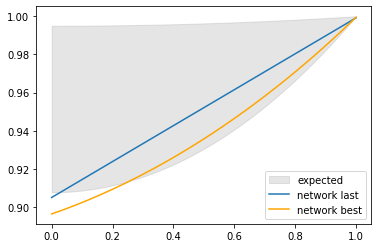

In [ ]:
import matplotlib.pyplot as plt

xspace = np.linspace(*x_bounds, 100)

plotting.show_c2varied_plot(plotting.actual_func, xspace, plotting.c2_bounds)
plt.plot(xspace, y_prediction_last_lambd(xspace), label='network last')
plt.plot(xspace, y_prediction_best_lambd(xspace), color='orange', label='network best')
plt.legend(loc=4)
plt.show()

In [ ]:
# c1_integrated_model = network.get_integrated_model_nolambdify(y_prediction_best)

In [ ]:
# TODO:
# sp.integrate(c1_integrated_model, (network.x, 0, 1))